In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [84]:
juvenile_history_path = '../../2_data_preparation/outputs/juvenile_history_cleaned.csv.gz'
juvenile_history = pd.read_csv(
    filepath_or_buffer=juvenile_history_path,
    dtype={
        "idnJuvenileHistory": "Int64",
        "idnCase": "Int64",
        "idnProceeding": "Int64",
        "idnJuvenile": "category",
    },
    low_memory=False,
)

### JuvenileHistory Table

The `JuvenileHistory` table is a **junction table** that contains foreign keys linking to core case tables and lookup tables. It represents many-to-many relationships between juveniles and immigration proceedings.

**Key columns:**
- `idnJuvenileHistory` — Primary key
- `idnCase` — Foreign key to the `Case` table
- `idnProceeding` — Foreign key to the `Proceeding` table
- `idnJuvenile` — Foreign key to the `Lookup Juvenile` table

This table acts as a bridge, allowing multiple juveniles to be associated with multiple cases and proceedings.

In [85]:
juvenile_history.head()

,idnJuvenileHistory,idnCase,idnProceeding,idnJuvenile
0,5,2046990,3200129,1
1,6,2047179,3199488,1
2,7,2047179,3199489,1
3,8,2047199,3199497,1
4,9,2047199,3199498,1


In [86]:
juvenile_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2857093 entries, 0 to 2857092
Data columns (total 4 columns):
 #   Column              Dtype   
---  ------              -----   
 0   idnJuvenileHistory  Int64   
 1   idnCase             Int64   
 2   idnProceeding       Int64   
 3   idnJuvenile         category
dtypes: Int64(3), category(1)
memory usage: 76.3 MB


In [87]:
rows = juvenile_history.shape[0]
unique_juvenile_case_ids_len = len(juvenile_history["idnCase"].unique())
case_counts = juvenile_history["idnCase"].value_counts()

print(f"Since 2008, the EOIR database contains {rows:,} juvenile records.")
print(f"The dataset includes {unique_juvenile_case_ids_len:,} unique juvenile case IDs.")
print(f"Median records per case ID: {case_counts.median()}")
print(f"Average records per case ID: {case_counts.mean():.2f}")
print(f"Cases with only one record: {(case_counts == 1).sum()}")

Since 2008, the EOIR database contains 2,857,093 juvenile records.
The dataset includes 1,917,264 unique juvenile case IDs.
Median records per case ID: 1.0
Average records per case ID: 1.49
Cases with only one record: 1269970


In [88]:
lookup_juvenile_path = '../../2_data_preparation/outputs/tblLookup_Juvenile.csv'
lookup_juvenile = pd.read_csv(
  filepath_or_buffer=lookup_juvenile_path,
  delimiter='\t',
  dtype={"idnJuvenile": "category"}  
)

In [89]:
display(lookup_juvenile)

,idnJuvenile,strCode,strDescription,DATCREATEDON,DATMODIFIEDON
0,1,J,Juvenile Case,2014-09-06 11:03:55.993,2017-04-07 21:42:18.000
1,2,J1,Juvenile has been released to guardian or has ...,2014-09-06 11:03:56.033,2017-04-07 21:42:34.000
2,3,J2,Unaccompanied Juvenile - Asylum,2014-09-06 11:03:56.033,2017-04-07 21:42:41.000
3,4,UJ,Unaccompanied Juvenile,2014-09-06 11:03:56.033,2014-09-06 17:39:29.000
4,5,NaN,Not Applicable,2017-10-20 22:32:47.537,2017-10-20 22:32:47.537
5,6,AJ,Accompanied Juvenile,2017-10-20 22:32:47.537,2017-10-20 22:32:47.537


In [90]:
missing_count = juvenile_history["idnJuvenile"].isna().sum()
print(f"Missing idnJuvenile values: {missing_count}")

Missing idnJuvenile values: 999


In [91]:
juvenile_history_with_lookup = juvenile_history.merge(
  lookup_juvenile,
  how='left',
  on='idnJuvenile'
)

In [92]:
juvenile_history_with_lookup.columns

Index(['idnJuvenileHistory', 'idnCase', 'idnProceeding', 'idnJuvenile',
       'strCode', 'strDescription', 'DATCREATEDON', 'DATMODIFIEDON'],
      dtype='object')

In [93]:
juvenile_history_with_lookup = juvenile_history_with_lookup[['idnJuvenileHistory', 'idnCase', 'idnProceeding', 'strCode', 'strDescription']]

In [94]:
juvenile_history_with_lookup.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2857093 entries, 0 to 2857092
Data columns (total 5 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   idnJuvenileHistory  Int64 
 1   idnCase             Int64 
 2   idnProceeding       Int64 
 3   strCode             object
 4   strDescription      object
dtypes: Int64(3), object(2)
memory usage: 117.2+ MB


In [95]:
juvenile_history_with_lookup.head()


,idnJuvenileHistory,idnCase,idnProceeding,strCode,strDescription
0,5,2046990,3200129,J,Juvenile Case
1,6,2047179,3199488,J,Juvenile Case
2,7,2047179,3199489,J,Juvenile Case
3,8,2047199,3199497,J,Juvenile Case
4,9,2047199,3199498,J,Juvenile Case


In [96]:
juvenile_history_with_lookup["strCode"] = juvenile_history_with_lookup["strCode"].fillna("Unknown")
juvenile_history_with_lookup["strDescription"] = juvenile_history_with_lookup["strDescription"].fillna("Not Applicable")

In [97]:
juvenile_history_with_lookup["strCode"].value_counts(dropna=False)

strCode
Unknown    1883374
UJ          452017
J           233667
AJ          227915
J1           59386
J2             734
Name: count, dtype: int64

The plot below shows the frequency of juvenile types using the `strCode` field from the `juvenile_history_with_lookup` dataset.  
Missing or unmatched `idnJuvenile` values were labeled as `"Unknown"` to ensure the dataset is complete and all records are represented.

A **logarithmic scale** is applied to the y-axis because the data is highly imbalanced — for example, the `"Unknown"` category includes over 1.8 million records, while `"AJ"` has only 734.  
Using a log scale allows smaller categories to remain visible and interpretable without compressing the larger bars too severely.

Actual record counts are displayed above each bar for clarity.

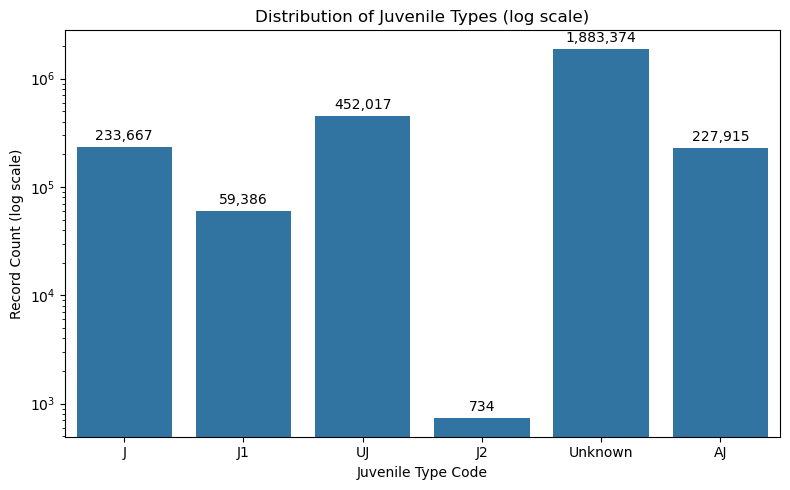

In [98]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(
    data=juvenile_history_with_lookup,
    x="strCode"
)

ax.set_yscale("log")
ax.set_title("Distribution of Juvenile Types (log scale)")
ax.set_xlabel("Juvenile Type Code")
ax.set_ylabel("Record Count (log scale)")

for container in ax.containers:
    ax.bar_label(
        container,
        labels=[f"{int(v):,}" for v in container.datavalues],
        fontsize=10,
        padding=3
    )

plt.tight_layout()
plt.show()

### Cases Table

The `Cases` table has already been cleaned and filtered to include only **juvenile cases**, based on a prior match using the `idnCase` field.  
Originally, the raw dataset contained over **11.7 million** records; after filtering, only juvenile-related entries were retained.

The dataset includes the following columns:

- `IDNCASE` – Primary key identifying each case
- `NAT` – Nationality of the alien
- `LANG` – Primary language spoken by the alien
- `CUSTODY` – Current custody status of the alien
- `CASE_TYPE` – Type of immigration case
- `LATEST_HEARING` – Date of the latest appearance before an immigration judge
- `LATEST_CAL_TYPE` – Type of hearing scheduled (`I` for individual, `M` for master)
- `DATE_OF_ENTRY` – Date the alien entered the United States
- `C_BIRTHDATE` – Birthdate of the alien
- `GENDER` – Sex of the alien
- `DATE_DETAINED` – Date the alien was detained
- `DATE_RELEASED` – Actual release date of the detained alien
- `DETENTION_DATE` – Date the alien entered the current detention facility

This table serves as the core source for analyzing case-level demographics, legal status, and custody timelines for juvenile immigration cases.

In [99]:
cases_path = '../../2_data_preparation/outputs/juvenile_cases_cleaned.csv.gz'

# the dtype schema below was pulled directly from the 02_clean_core_tables.ipynb notebook in the 2_data_preparation/notebooks/ folder
dtype = {
    "IDNCASE": "Int64",
    "NAT": "category",
    "LANG": "category",
    "CUSTODY": "category",
    "CASE_TYPE": "category",
    "LATEST_CAL_TYPE": "category",
    "GENDER": "category",
    "C_BIRTHDATE": "string",
    "DETENTION_DATE": "float64",
}

In [100]:
cases = pd.read_csv(
    filepath_or_buffer=cases_path,
    dtype=dtype,
    parse_dates=["LATEST_HEARING", "DATE_OF_ENTRY", "DATE_DETAINED", "DATE_RELEASED"],
    low_memory=False
)

In [101]:
cases.shape

(1858773, 13)

In [102]:
cases.head()

,IDNCASE,NAT,LANG,CUSTODY,CASE_TYPE,LATEST_HEARING,LATEST_CAL_TYPE,DATE_OF_ENTRY,C_BIRTHDATE,GENDER,DATE_DETAINED,DATE_RELEASED,DETENTION_DATE
0,13758313,GT,SP,N,RMV,NaN,NaN,2024-01-21,2/2008,F,NaN,NaT,NaN
1,14870586,MX,SP,D,RFR,2025-02-04 00:00:00.000,I,NaT,<NA>,NaN,2025-01-22 00:00:00.000,NaT,NaN
2,14870588,GT,SP,R,WHO,2025-07-31 00:00:00.000,M,NaT,6/1997,F,2025-01-29 00:00:00.000,2025-02-06,NaN
3,13816559,MX,SP,N,RMV,2027-02-18 00:00:00.000,I,NaT,5/2020,M,NaN,NaT,NaN
4,13816560,MX,SP,N,RMV,2027-02-18 00:00:00.000,I,NaT,5/2021,F,NaN,NaT,NaN


In [103]:
cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1858773 entries, 0 to 1858772
Data columns (total 13 columns):
 #   Column           Dtype         
---  ------           -----         
 0   IDNCASE          Int64         
 1   NAT              category      
 2   LANG             category      
 3   CUSTODY          category      
 4   CASE_TYPE        category      
 5   LATEST_HEARING   object        
 6   LATEST_CAL_TYPE  category      
 7   DATE_OF_ENTRY    datetime64[ns]
 8   C_BIRTHDATE      string        
 9   GENDER           category      
 10  DATE_DETAINED    object        
 11  DATE_RELEASED    datetime64[ns]
 12  DETENTION_DATE   float64       
dtypes: Int64(1), category(6), datetime64[ns](2), float64(1), object(2), string(1)
memory usage: 115.3+ MB


In [104]:
null_counts = cases.isna().sum()
percent_missing = (null_counts / len(cases)) * 100

missing_summary = pd.DataFrame({
    "Missing Count": null_counts,
    "Missing %": percent_missing.round(2)
}).sort_values(by="Missing Count", ascending=False)

display(missing_summary)

,Missing Count,Missing %
DETENTION_DATE,1858773,100.00
DATE_RELEASED,1411804,75.95
DATE_DETAINED,1053320,56.67
GENDER,488535,26.28
DATE_OF_ENTRY,480722,25.86
C_BIRTHDATE,446724,24.03
LATEST_CAL_TYPE,303538,16.33
LATEST_HEARING,296813,15.97
NAT,3057,0.16
LANG,1692,0.09


The `DETENTION_DATE` column is entirely null (100% missing) and therefore will be dropped from the dataset

In [105]:
cases = cases.drop('DETENTION_DATE', axis=1)

In [106]:
filtered_cases = cases[cases['GENDER'].isin(['M', 'F'])].copy()

# drop unused categories
filtered_cases['GENDER'] = filtered_cases['GENDER'].cat.remove_unused_categories()

gender = filtered_cases['GENDER'].value_counts().reset_index()
gender.columns = ['GENDER', 'COUNT']

gender["RATIO (%)"] = (gender["COUNT"] / gender["COUNT"].sum()) * 100
gender["RATIO (%)"] = gender["RATIO (%)"].round()

display(gender)

,GENDER,COUNT,RATIO (%)
0,M,875507,64.0
1,F,494724,36.0


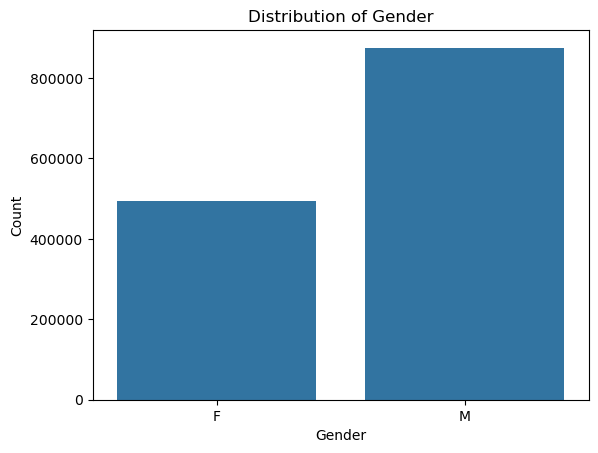

In [107]:
sns.barplot(data=gender, x='GENDER', y='COUNT')
plt.title("Distribution of Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

### 🚧 Work in Progress

This analysis is not yet complete. Please be patient as we continue working on the next steps.